In [1]:
"""This script has following capabilities:
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob
import shutil
import re

from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
from scipy.interpolate import make_interp_spline
from sklearn.kernel_ridge import KernelRidge

In [185]:
# Defn:
def read_file(filename, skiplines):
    with open(filename) as file:
        lines = file.readlines()
        total_lines = len(lines)
#         print('Total lines:', total_lines)
    # Read the data:
    rlines = lines[skiplines:]
    # Extract data from file
    data = np.array([list(map(float, line.strip().split())) for line in rlines])
#     print("Shape of data:", data.shape)
    header = lines[skiplines-1].strip().split()
    dt = data[1][0] - data[0][0]; # Time interval between data
    return header, dt, data

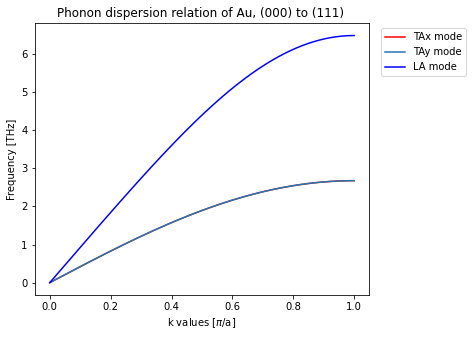

In [243]:
# Reading the phonon dispersion data:
filename = '../Au_MNL_varying_interfaces/Au_morse_111.disp'
with open(filename, 'r') as file:
    lines = file.readlines()

data = [line.split() for line in lines if not line.startswith('#')]

data = np.array(data)
data = data.astype(np.float64)
cm_2_THz = 29979245800/1e12
TAx = data[0::3][:, 1]*cm_2_THz  # in (cm-1)
TAy = data[1::3][:, 1]*cm_2_THz  # in (cm-1)
LA = data[2::3][:, 1]*cm_2_THz   # in (cm-1)
k_val = (data[0::3][:, 0] - 1)/500

fig = plt.figure(figsize=(6,5))
plt.plot(k_val, TAx, '-r', label='TAx mode')
plt.plot(k_val, TAy, '-', label='TAy mode')
plt.plot(k_val, LA, '-b', label='LA mode')
plt.xlabel('k values [$\pi$/a]')
plt.ylabel('Frequency [THz]')
# plt.xlim(0,.2)
# plt.ylim(0, 1)

plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.title('Phonon dispersion relation of Au, (000) to (111) ')
plt.show()


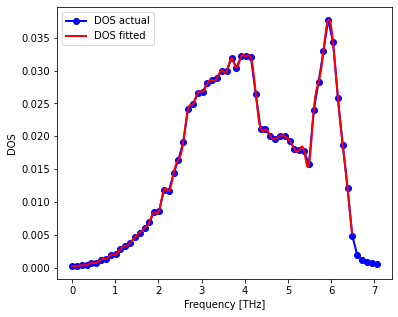

In [251]:
# Reading the Phonon Density of States D(w):
_, _, DOS = read_file('../Au_MNL_varying_interfaces/Au_morse_111.dens', 2)

DOS[:, 0] = DOS[:, 0]*cm_2_THz   # Converting

# Create and fit the Kernel Ridge Regression model 
krr_dos = KernelRidge(alpha=0.0001, kernel='rbf', gamma=60)  # Example hyperparameters
krr_dos.fit(DOS[:, 0].reshape(-1, 1), DOS[:, 1])

# Make predictions using the trained model
dos_fit = krr_dos.predict(LA.reshape(-1, 1))

fig = plt.figure(figsize=(6,5))
plt.plot(DOS[:, 0], DOS[:, 1], 'ob-', linewidth=2, label='DOS actual')  
plt.plot(LA, dos_fit, 'r-', linewidth=2, label='DOS fitted')  
plt.xlabel('Frequency [THz]')
plt.ylabel('DOS')
plt.tick_params(axis='both', which='major')
plt.legend()
plt.savefig("./Mode_resolved_ETC/DOS.png", dpi= 200, bbox_inches = 'tight', facecolor="w")
plt.show()

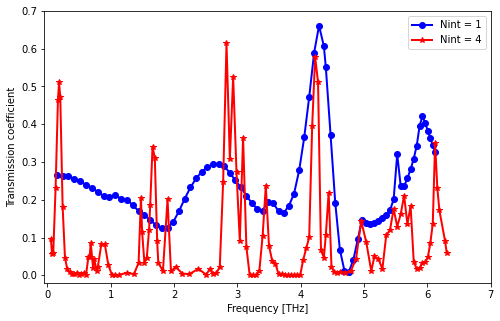

In [252]:
# Comparing Au/MNL single interface vs Au/MNL Nint=4
#-------------------------------------------------------------------------------------------------------------------------
# Read the data 
# Single interface: Au/MNL, b=1
header, _, sing_int = read_file('./ETC_ERC_data/Au_8400_C_7000_freq_var/ETC_var_freq.dat', 0)

# Multiple interface: Au/MNL, b=2, Nint=4, ETC vs Freq data:
header, dt, multi_int = read_file('./ETC_ERC_data/Au_MNL_b-2/ETC_var_freq.dat', 0)

fig = plt.figure(figsize=(8,5))
plt.plot(sing_int[:, 0], sing_int[:, 1], 'ob-', linewidth=2, label='Nint = 1')  
plt.plot(multi_int[:, 0], multi_int[:, 1], '*r-', linewidth=2, label='Nint = 4')     
plt.xlim(-0.05, 7)
plt.ylim(-0.02, 0.7)
plt.xlabel('Frequency [THz]')
plt.ylabel('Transmission coefficient')
plt.tick_params(axis='both', which='major')
plt.legend()
plt.savefig("./Mode_resolved_ETC/Comparison_ETC_freq_var.tiff", dpi= 200, 
            bbox_inches = 'tight', facecolor="w")
plt.show()

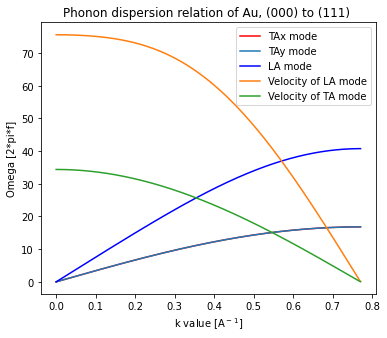

In [253]:
fig = plt.figure(figsize=(6,5))
a0 = 4.079016
const = np.pi/a0
k = k_val*const
velocity = np.gradient(2*np.pi*LA, k)

plt.plot(k, 2*np.pi*TAx, '-r', label='TAx mode')
plt.plot(k, 2*np.pi*TAy, '-', label='TAy mode')
plt.plot(k, 2*np.pi*LA, '-b', label='LA mode')
# plt.plot(k, 75*k, '-c')
plt.plot(k, velocity, label='Velocity of LA mode')
plt.plot(k, np.gradient(2*np.pi*TAx, k), label='Velocity of TA mode')

plt.xlabel('k value [A$^-$$^1$]')
plt.ylabel('Omega [2*pi*f]')
# plt.xlim(0,.2)
# plt.ylim(0, 1)

# plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.legend()
plt.title('Phonon dispersion relation of Au, (000) to (111) ')
plt.savefig("./Mode_resolved_ETC/Disp_relation_vel.png", dpi= 200, bbox_inches = 'tight', facecolor="w")
plt.show()

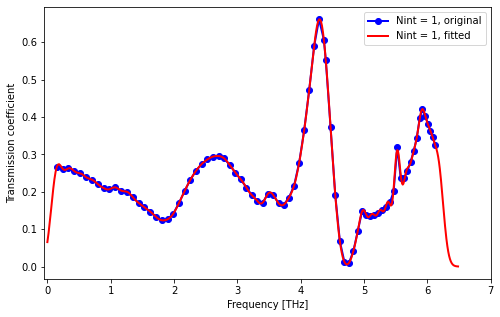

In [254]:
# Create and fit the Kernel Ridge Regression model 
krr_sing_int = KernelRidge(alpha=0.0001, kernel='rbf', gamma=60)  # Example hyperparameters
krr_sing_int.fit(sing_int[:, 0].reshape(-1, 1), sing_int[:, 1])

# Make predictions using the trained model
ETC_sing = krr_sing_int.predict(LA.reshape(-1, 1))

fig = plt.figure(figsize=(8,5))
plt.plot(sing_int[:, 0], sing_int[:, 1], 'ob-', linewidth=2, label='Nint = 1, original')  
plt.plot(LA, ETC_sing, 'r-', linewidth=2, label='Nint = 1, fitted')  
# plt.plot(LA[8:-100], ETC_sing*velocity[8:-100], 'r-', linewidth=2, label='Nint = 1, pred')
plt.xlim(-0.05, 7)
# plt.ylim(-0.02, 0.7)
plt.xlabel('Frequency [THz]')
plt.ylabel('Transmission coefficient')
plt.tick_params(axis='both', which='major')
plt.legend()
plt.savefig("./Mode_resolved_ETC/Sing_ETC_freq_var.png", dpi= 200, 
            bbox_inches = 'tight', facecolor="w")
plt.show()

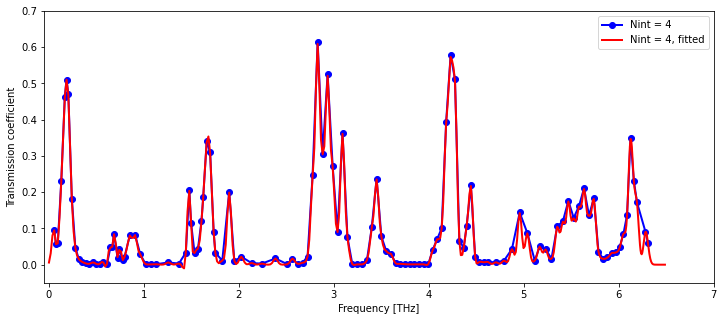

In [257]:
# Create and fit the Kernel Ridge Regression model 
krr_multi_int = KernelRidge(alpha=.01, kernel='rbf', gamma=1000)  # Example hyperparameters
krr_multi_int.fit(multi_int[:, 0].reshape(-1, 1), multi_int[:, 1])

# Make predictions using the trained model
ETC_multi = krr_multi_int.predict(LA.reshape(-1, 1))

fig = plt.figure(figsize=(12,5))
plt.plot(multi_int[:, 0], multi_int[:, 1], 'ob-', linewidth=2, label='Nint = 4')  
plt.plot(LA, ETC_multi, 'r-', linewidth=2, label='Nint = 4, fitted')     
plt.xlim(-0.05, 7)
plt.ylim(-0.05, 0.7)
plt.xlabel('Frequency [THz]')
plt.ylabel('Transmission coefficient')
plt.tick_params(axis='both', which='major')
plt.legend()
plt.savefig("./Mode_resolved_ETC/Multi_ETC_freq_var.png", dpi= 200, 
            bbox_inches = 'tight', facecolor="w")
plt.show()

In [258]:
dk_val = k_val[2] - k_val[1]
constant = 1000*8*dk_val*1.380649/a0**3
ITC_sing = np.sum(ETC_sing[8:-100]*velocity[8:-100])*constant # MW/m2K
ITC_multi = np.sum(ETC_multi[8:-100]*velocity[8: -100])*constant # MW/m2K

print(f'Single:{ITC_sing}, Multi:{ITC_multi}, Ratio:{ITC_sing/ITC_multi}')

Single:1859.0390816723987, Multi:640.4678773880071, Ratio:2.9026265755185703


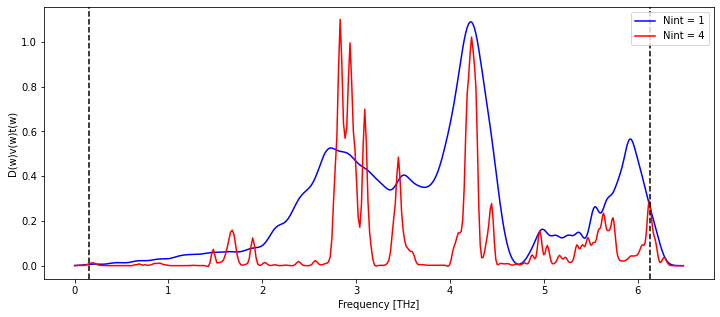

Single:1.5932093025610783, Multi:0.5891570778024224, Ratio:2.70421821715833


In [267]:
# For single interface:
# dos* vel* transmission coeff
cond_sing = dos_fit*velocity*ETC_sing
cond_multi = dos_fit*velocity*ETC_multi

fig = plt.figure(figsize=(12,5))
plt.plot(LA, cond_sing, 'b',label='Nint = 1')
plt.plot(LA, cond_multi, 'r',label='Nint = 4')
plt.xlabel('Frequency [THz]')
plt.ylabel('D(w)v(w)t(w)')
plt.axvline(LA[8], color='k', ls='--')
plt.axvline(LA[-100], color='k', ls='--')
plt.legend()
plt.savefig("./Mode_resolved_ETC/D_v_t_plot.png", dpi= 200, 
            bbox_inches = 'tight', facecolor="w")
plt.show()

# Calculating the integration:
int_sing = np.trapz(cond_sing[8:-100], LA[8:-100])
int_multi = np.trapz(cond_multi[8:-100], LA[8:-100])

print(f'Single:{int_sing}, Multi:{int_multi}, Ratio:{int_sing/int_multi}')


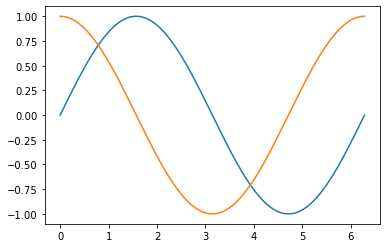

In [177]:
x = np.linspace(0, 2*np.pi, 1000)
plt.plot(x, np.sin(x), label='Sin')
plt.plot(x, np.gradient(np.sin(x), x), label='Cos')
plt.show()